In [1]:
from sympy import *
import re
from dwave.system import DWaveSampler, EmbeddingComposite
import dimod
import pandas as pd
import pickle
import os
import os.path
import dwave.inspector

import json
from dimod.serialization.json import DimodEncoder, DimodDecoder

init_printing()

In [2]:
sampler = DWaveSampler(region='eu-central-1')  # alternativ um eine QPU in Nordamerika auszuwählen: sampler = DWaveSampler(region='na-west-1')
solver = EmbeddingComposite(sampler)

print(f'Selected QPU {sampler.properties["chip_id"]} with {len(sampler.nodelist)} qubits')

Selected QPU Advantage_system5.4 with 5614 qubits


In [3]:
def init(N):
    config = {
        
        143:((4,4),2),

        437: ((5,5),3),

        493: ((5,5),3),

        59989:((8,8),3),

        376289:((10,10),3)
    }
    return config[N]

In [4]:
N = 437
dim, BLOCKSIZE = init(N)

In [5]:
# read cost equation from file
#N = 143
#dim = (4,4)

filepath = os.path.join(os.getcwd(), 'problems',f'{dim[0]}_{dim[1]}_{N}.pickle')
with open(filepath, 'rb') as f:
    p,q,c, cost_expr =pickle.load(f)
(p,q,c,cost_expr)

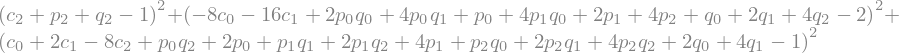

In [6]:
cost_expr = Add(*[block_expr ** 2  for block_expr in cost_expr])
cost_expr

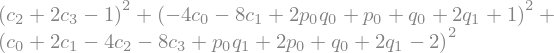

In [9]:
# bsc thesis cost expr
cost_expr = sympify('2*(1+p0*q0+q1-(4*c1+2*c0))+p0+q0-1')**2 + sympify('2*(q1+p0+c1-(4*c3+2*c2))+q0+p0*q1+1+c0-3') **2 + sympify('2*c3+1+c2-2') ** 2
cost_expr

In [19]:
# expand and simplify with x**2  = x for x = 0,1
cost_expr = expand(cost_expr).subs([(term**2, term) for term in c + tuple([symbols('c3')]) + p + q])
print(latex(cost_expr))


68 c_{0} c_{1} - 8 c_{0} c_{2} - 16 c_{0} c_{3} - 16 c_{0} p_{0} q_{0} + 2 c_{0} p_{0} q_{1} - 4 c_{0} p_{0} - 6 c_{0} q_{0} - 12 c_{0} q_{1} + 5 c_{0} - 16 c_{1} c_{2} - 32 c_{1} c_{3} - 32 c_{1} p_{0} q_{0} + 4 c_{1} p_{0} q_{1} - 8 c_{1} p_{0} - 12 c_{1} q_{0} - 24 c_{1} q_{1} + 44 c_{1} + 68 c_{2} c_{3} - 8 c_{2} p_{0} q_{1} - 16 c_{2} p_{0} - 8 c_{2} q_{0} - 16 c_{2} q_{1} + 31 c_{2} - 16 c_{3} p_{0} q_{1} - 32 c_{3} p_{0} - 16 c_{3} q_{0} - 32 c_{3} q_{1} + 96 c_{3} + 10 p_{0} q_{0} q_{1} + 22 p_{0} q_{0} + 17 p_{0} q_{1} - p_{0} + 8 q_{0} q_{1} + 4 q_{1} + 6


In [17]:
# check cost expr (bsc thesis)
p0 ,q0, q1, c0, c1, c2, c3 = symbols("p0 q0 q1 c0 c1 c2 c3")
subs = [
    (p0,1),
    (q0,0),
    (q1,1),
    (c0,1),
    (c1,0),
    (c2,1),
    (c3,0)
]

cost_expr.subs(subs)

In [23]:
# higher order to second order
# there are no higher order c terms 
# therefore we only consider combinations of p and q
pq_combos = expand(Mul(*[sum(sym_list) for sym_list in [p,q]])).args

# generate necessary t symbols for substitution
t = symbols(' '.join([f't{i}' for i in range(len(pq_combos))]))

# construct subs dict
sub_dict = [[(pq, t_sym)] for pq, t_sym in zip(pq_combos,t) ]
print (sub_dict)

def construct_equality_constraint(pqt):
    return (
        8*(pqt[0]*pqt[1]-2*pqt[0]*pqt[2]-2*pqt[1]*pqt[2]+3*pqt[2]) 
    )
print(sub_dict)
pprint(cost_expr)

lower_order_expr = cost_expr.copy()


constraints = []
modified = True

# run until no more modifiable terms
while modified:
    modified = False
    modified_terms = []
    terms =[_arg for _arg in lower_order_expr.args]

    for term in terms:
        if (len(term.free_symbols) >= 3):
            print(term)
            for sub_rule in sub_dict:
                sub_term = term.subs(sub_rule)
                # variable replacement starting
                if sub_term != term:
                    print(sub_rule)
                    pqt = list(sub_rule[0][0].args) + [sub_rule[0][1]]
                    print(pqt)
                    constraints.append(construct_equality_constraint(pqt))
                    term = sub_term
                    print(f"Modified term {term}")
                    print(f"Constraint: {constraints[-1]}")
                    modified = True # loop until no more modifications made
                    break
            print("-------------")
        
        modified_terms.append(term)
    lower_order_expr = Add(*modified_terms) 
print(constraints)
lower_order_expr += Add(*constraints) 
print(modified_terms)



[[(p0*q0, t0)], [(p0*q1, t1)], [(p0*q2, t2)], [(p1*q0, t3)], [(p1*q1, t4)], [(p1*q2, t5)], [(p2*q0, t6)], [(p2*q1, t7)], [(p2*q2, t8)]]
[[(p0*q0, t0)], [(p0*q1, t1)], [(p0*q2, t2)], [(p1*q0, t3)], [(p1*q1, t4)], [(p1*q2, t5)], [(p2*q0, t6)], [(p2*q1, t7)], [(p2*q2, t8)]]
68⋅c₀⋅c₁ - 8⋅c₀⋅c₂ - 16⋅c₀⋅c₃ - 16⋅c₀⋅p₀⋅q₀ + 2⋅c₀⋅p₀⋅q₁ - 4⋅c₀⋅p₀ - 6⋅c₀⋅q₀ -
 12⋅c₀⋅q₁ + 5⋅c₀ - 16⋅c₁⋅c₂ - 32⋅c₁⋅c₃ - 32⋅c₁⋅p₀⋅q₀ + 4⋅c₁⋅p₀⋅q₁ - 8⋅c₁⋅p₀ - 
12⋅c₁⋅q₀ - 24⋅c₁⋅q₁ + 44⋅c₁ + 68⋅c₂⋅c₃ - 8⋅c₂⋅p₀⋅q₁ - 16⋅c₂⋅p₀ - 8⋅c₂⋅q₀ - 16⋅
c₂⋅q₁ + 31⋅c₂ - 16⋅c₃⋅p₀⋅q₁ - 32⋅c₃⋅p₀ - 16⋅c₃⋅q₀ - 32⋅c₃⋅q₁ + 96⋅c₃ + 10⋅p₀⋅q
₀⋅q₁ + 22⋅p₀⋅q₀ + 17⋅p₀⋅q₁ - p₀ + 8⋅q₀⋅q₁ + 4⋅q₁ + 6
-32*c1*p0*q0
[(p0*q0, t0)]
[p0, q0, t0]
Modified term -32*c1*t0
Constraint: 8*p0*q0 - 16*p0*t0 - 16*q0*t0 + 24*t0
-------------
-16*c0*p0*q0
[(p0*q0, t0)]
[p0, q0, t0]
Modified term -16*c0*t0
Constraint: 8*p0*q0 - 16*p0*t0 - 16*q0*t0 + 24*t0
-------------
-16*c3*p0*q1
[(p0*q1, t1)]
[p0, q1, t1]
Modified term -16*c3*t1
Constraint: 8*p0*q1 - 16*p0*t1 - 16*q1*

In [24]:
latex(lower_order_expr)

'68 c_{0} c_{1} - 8 c_{0} c_{2} - 16 c_{0} c_{3} - 4 c_{0} p_{0} - 6 c_{0} q_{0} - 12 c_{0} q_{1} - 16 c_{0} t_{0} + 2 c_{0} t_{1} + 5 c_{0} - 16 c_{1} c_{2} - 32 c_{1} c_{3} - 8 c_{1} p_{0} - 12 c_{1} q_{0} - 24 c_{1} q_{1} - 32 c_{1} t_{0} + 4 c_{1} t_{1} + 44 c_{1} + 68 c_{2} c_{3} - 16 c_{2} p_{0} - 8 c_{2} q_{0} - 16 c_{2} q_{1} - 8 c_{2} t_{1} + 31 c_{2} - 32 c_{3} p_{0} - 16 c_{3} q_{0} - 32 c_{3} q_{1} - 16 c_{3} t_{1} + 96 c_{3} + 46 p_{0} q_{0} + 49 p_{0} q_{1} - 48 p_{0} t_{0} - 64 p_{0} t_{1} - p_{0} + 8 q_{0} q_{1} - 48 q_{0} t_{0} + 10 q_{1} t_{0} - 64 q_{1} t_{1} + 4 q_{1} + 72 t_{0} + 96 t_{1} + 6'

In [9]:
def to_qubo(lower_order_expr):
    # replace all p,q,cs, and ts with s0,... sn
    #s = symbols(' '.join([f's{i}' for i in range(len(p+q+c+t))]))

    # construct replacement dict
    #pqct_repl = {variable: s[i] for i, variable in enumerate(p+q+c+t)}
    #lower_order_expr = lower_order_expr.subs(pqct_repl)

    # construct qubo with named variables s, remove offset 
    lower_order_coeff = lower_order_expr.as_coefficients_dict()
    offset = lower_order_coeff[1]
    qubo = {(tuple(str(k).split('*'))*2)[0:2] : v  for k,v in lower_order_coeff.items() if len(str(k).split('*')) < 3 and k != 1}
    return (qubo, offset)


In [10]:
paper_expr_str = "43c1 + 120c2 + 5c3 + 44c4 + 3p1 - 11p2 + 3q1 - 11q2 + 444t1 + 252t2 + 372t3 + 252t4 + 68c1 c2 - 8c1 c3 -16c1 c4 - 16c2 c3 - 32c2 c4 + 68c3 c4 - 4c1 p1 - 16c1 p2 - 8c2 p1 - 32c2 p2 - 16c3 p1 + 2c3 p2 - 32c4 p1 + 4c4 p2 -4c1 q1 - 16c1 q2 - 8c2 q1 - 32c2 q2 - 16c3 q1 + 2c3 q2 - 32c4 q1 + 4c4 q2 - 16c1 t1 + 2c1 t2 - 32c2 t1 + 4c1 t3+4c2 t2 + 2c1 t4 + 8c2 t3 - 8c3 t2 + 4c2 t4 - 16c3 t3 - 16c4 t2 - 8c3 t4 - 32c4 t3 - 16c4 t4 + 4p1 p2 + 158p1 q1+95p1 q2 + 95p2 q1 + 142p2 q2 + 4q1 q2 - 296p1 t1 - 168p1 t2 + 12p2 t1 + 12p2 t2 - 248p2 t3 - 168p2 t4 - 296q1 t1+12q2 t1 - 168q2 t2 - 168q1 t4 - 248q2 t3 + 12q2 t4 + 2t1 t3 + 14"
# make string compatible with sympy expr parsing by adding * between factors
while(re.sub(r'(\w)\s+(\w)', r'\1*\2', paper_expr_str) != paper_expr_str):
    paper_expr_str = re.sub(r'(\w)\s+(\w)', r'\1*\2', paper_expr_str) 
paper_modified_expr_str = re.sub(r'(\d)([a-zA-Z])', r'\1*\2', paper_expr_str)
paper_modified_expr_str = parse_expr(paper_modified_expr_str)


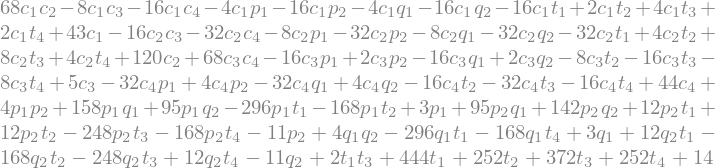

In [11]:
paper_modified_expr_str

In [12]:
# Run bqms
def run_get_success_rates(bqm, N,num_reads = 1000):
    print(N)
    success_rates = {}
    results = {}
    valids = {}
    response = solver.sample(bqm, num_reads = num_reads, return_embedding=True)
    result = response.to_pandas_dataframe().sort_values(by='energy')
    result['a'] = result.filter(regex='^p[0-9]+$').apply(lambda row: int(''.join(['1']+list(row.values.astype(str))+['1'])[::-1],2), axis=1) 
    result['b'] = result.filter(regex='^q[0-9]+$').apply(lambda row: int(''.join(['1']+list(row.values.astype(str))+['1'])[::-1],2), axis=1)
    result['valid'] = result['a'] * result['b'] == int(N)
    valid = result[(result['valid'] == True)]
    print(valid)
    success_rate = 0 if valid.empty else valid['num_occurrences'].sum()/ num_reads *100
    print(result)
    print(success_rate)
    #if not valids.empty:
    #    print(valids)
    #print(f"N = {N} Success rate: {success_rate}%")
    #dwave.inspector.show(response)
    #if success_rate != 0:
    return (result, success_rate)

In [13]:
success_rates = [[],[]]
print(N)
embedding = []
#for i,expr in enumerate([lower_order_expr, paper_modified_expr_str]):
for i,expr in enumerate([lower_order_expr]):

    runs = 1

    for _ in range(runs):
        qubo, offset = to_qubo(expr)
        # send the code to DWAVE
        bqm = dimod.BinaryQuadraticModel.from_qubo(Q = qubo, offset=offset)
        print(offset)
     #   success_rates[i].append(run_get_success_rates(bqm, N)[1])

        # pickle bqm
        filepath = os.path.join(os.getcwd(), 'bqms',f'{dim[0]}_{dim[1]}_{N}.json')
        with open(filepath, 'w') as f:
            json.dump(dimod.binary.BinaryQuadraticModel.to_serializable(bqm),f)

#success_rates_df = pd.DataFrame({'expr': success_rates[0], 'paper_expr':success_rates[1]})
success_rates_df = pd.DataFrame({'expr': success_rates[0]})

success_rates_df


437
6


,expr


In [14]:
embedding

In [15]:
success_rates_df.mean()

expr   NaN
dtype: float64

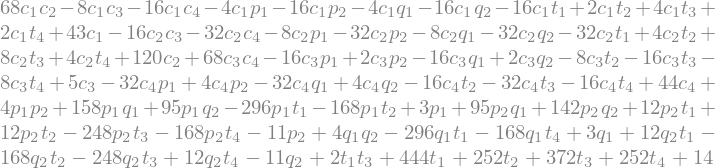

In [16]:
paper_modified_expr_str

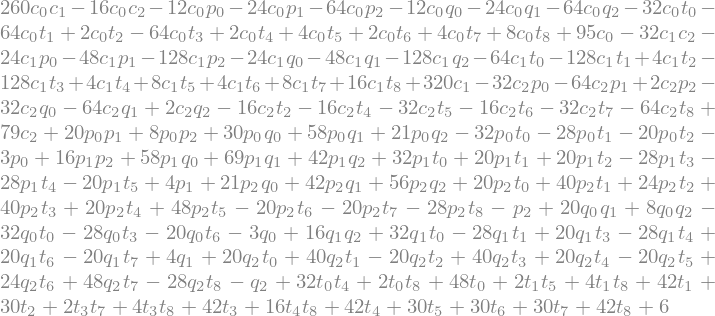

In [17]:
lower_order_expr

In [ ]:
sub_dict

[[(p₀⋅q₀, t₀)], [(p₀⋅q₁, t₁)], [(p₁⋅q₀, t₂)], [(p₁⋅q₁, t₃)]]